# Traffic Forecasting (Beginner Level)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet

In [2]:
# loading the dataset
df = pd.read_csv('./data/TrafficDataTimeSeriesAnalysis.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


# Data Cleaning

In [3]:
# checking for null rows
df.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


Number of rows: 18288 entries.

The Datetime column is of data type 'object', we must convert it.

In [5]:
# Datetime format: 25-08-2012 00:00 (dd-mm-YYYY HH:MM)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


# Exploratory Data Analysis (EDA)

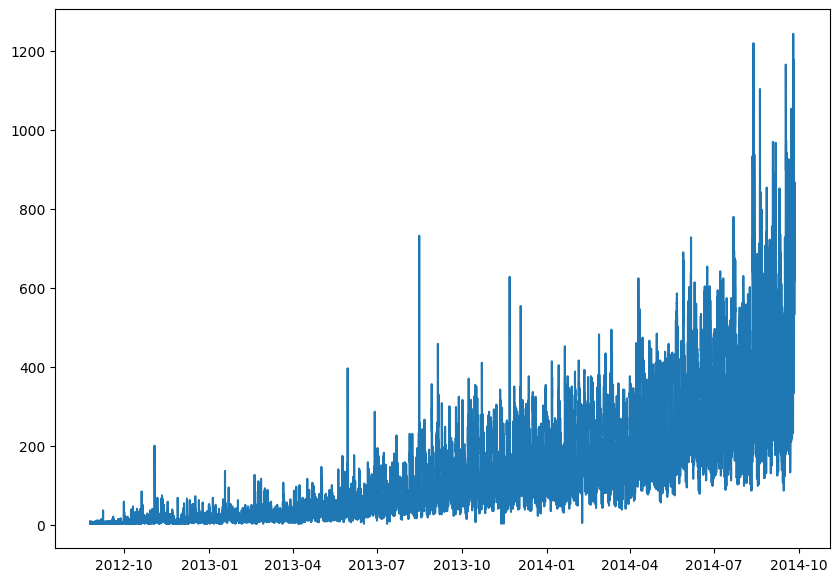

In [6]:
plt.figure(figsize=(10,7))
plt.plot(df['Datetime'], df['Count'])

Data points are too close to each other, let's take a closer look from 2014:

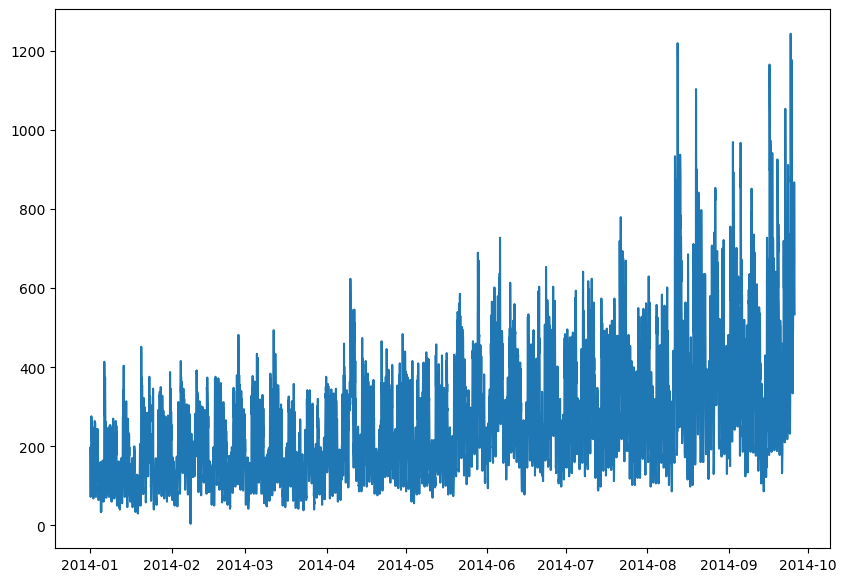

In [7]:
# Filter the DataFrame for records from 2014 onwards
df_filtered = df[df['Datetime'] >= '2014-01-01 00:00']

plt.figure(figsize=(10,7))
plt.plot(df_filtered['Datetime'], df_filtered['Count'])

Data points are still too close to each other. Zooming into the graph even further: 

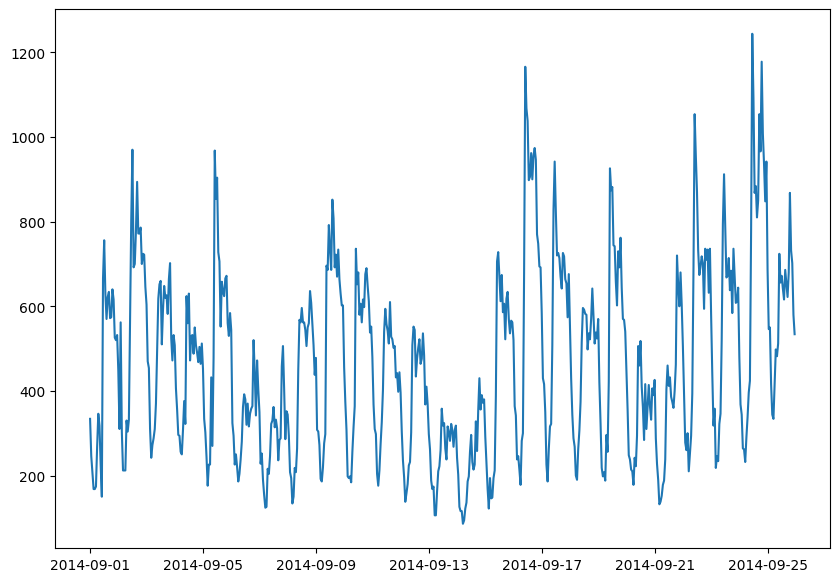

In [8]:
# Filter the DataFrame for records from 2014 onwards
df_filtered = df[df['Datetime'] >= '2014-09-01 00:00']

plt.figure(figsize=(10,7))
plt.plot(df_filtered['Datetime'], df_filtered['Count'])

This is better. We can see that the traffic volume changes quite during each day. This makes sense as there could be more traffic in the rush hour of the mornings and evenings while being relatively less during off-peak times.

# ML Model: Prophet


## Data Prep for the Model

In [9]:
df.index = df['Datetime']
df['y'] = df['Count']
df.drop(columns=['ID', 'Datetime', 'Count'], axis=1, inplace=True)
# grouping by the index by Day and summing all the rows.
df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


Considering total traffic of the entire day (rather than different times of the day, to reduce the data fed to the model)

In [10]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29


#### Input Split

In [11]:
size = 60
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=size/len(df), shuffle=False)

In [12]:
train.tail()

,y,ds
Datetime,,
2014-07-23,10130,2014-07-23
2014-07-24,8156,2014-07-24
2014-07-25,7192,2014-07-25
2014-07-26,6562,2014-07-26
2014-07-27,6094,2014-07-27


In [13]:
test.head()

,y,ds
Datetime,,
2014-07-28,8546,2014-07-28
2014-07-29,8218,2014-07-29
2014-07-30,8498,2014-07-30
2014-07-31,8740,2014-07-31
2014-08-01,9186,2014-08-01


In [14]:
test.tail(2)

,y,ds
Datetime,,
2014-09-24,16856,2014-09-24
2014-09-25,14152,2014-09-25


## Train the Model

In [15]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(train)

12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# forecasting for a period of 60 days (since the data frame for each row is in-terms of day)
future = model.make_future_dataframe(periods=60)
future

,ds
0,2012-08-25
1,2012-08-26
2,2012-08-27
3,2012-08-28
4,2012-08-29
...,...
757,2014-09-21
758,2014-09-22
759,2014-09-23
760,2014-09-24


In [17]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-476.485324,-1755.891722,180.691117,-476.485324,-476.485324,-342.722218,-342.722218,-342.722218,-846.193710,-846.193710,-846.193710,503.471492,503.471492,503.471492,0.0,0.0,0.0,-819.207542
1,2012-08-26,-469.473226,-1912.822867,-9.947402,-469.473226,-469.473226,-458.413195,-458.413195,-458.413195,-967.165877,-967.165877,-967.165877,508.752683,508.752683,508.752683,0.0,0.0,0.0,-927.886421
2,2012-08-27,-462.461129,-495.040593,1414.922548,-462.461129,-462.461129,943.764348,943.764348,943.764348,431.216364,431.216364,431.216364,512.547984,512.547984,512.547984,0.0,0.0,0.0,481.303219
3,2012-08-28,-455.449031,-473.984644,1514.001051,-455.449031,-455.449031,954.544700,954.544700,954.544700,439.575750,439.575750,439.575750,514.968950,514.968950,514.968950,0.0,0.0,0.0,499.095669
4,2012-08-29,-448.436934,-445.866137,1505.861880,-448.436934,-448.436934,915.897573,915.897573,915.897573,399.763598,399.763598,399.763598,516.133975,516.133975,516.133975,0.0,0.0,0.0,467.460639


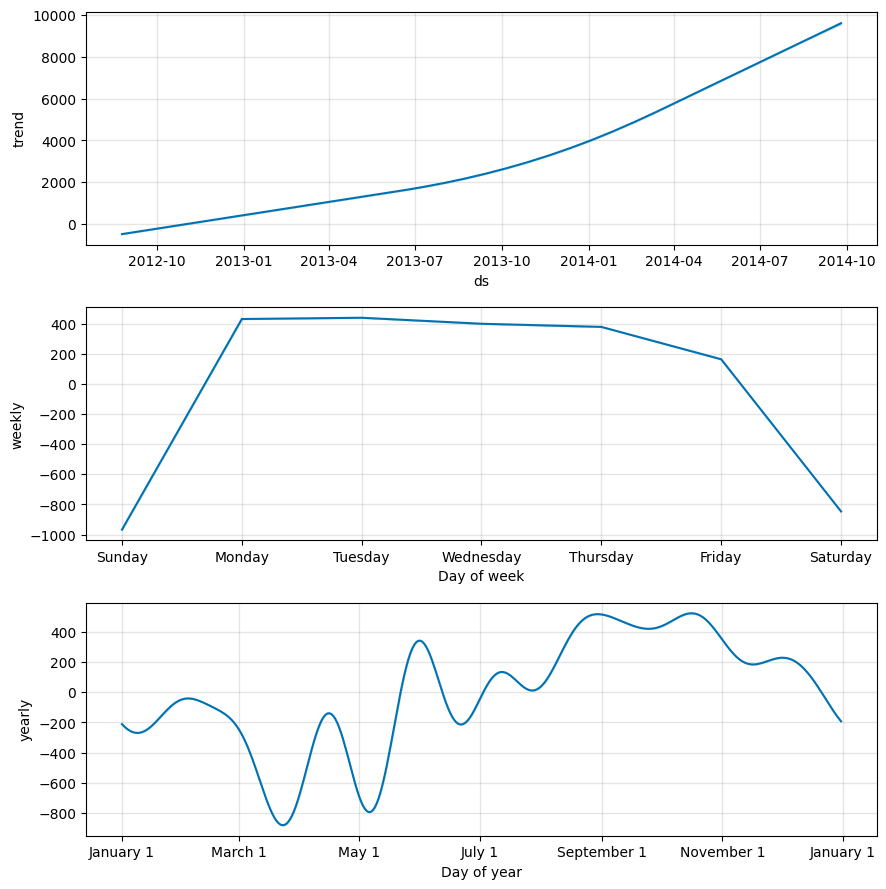

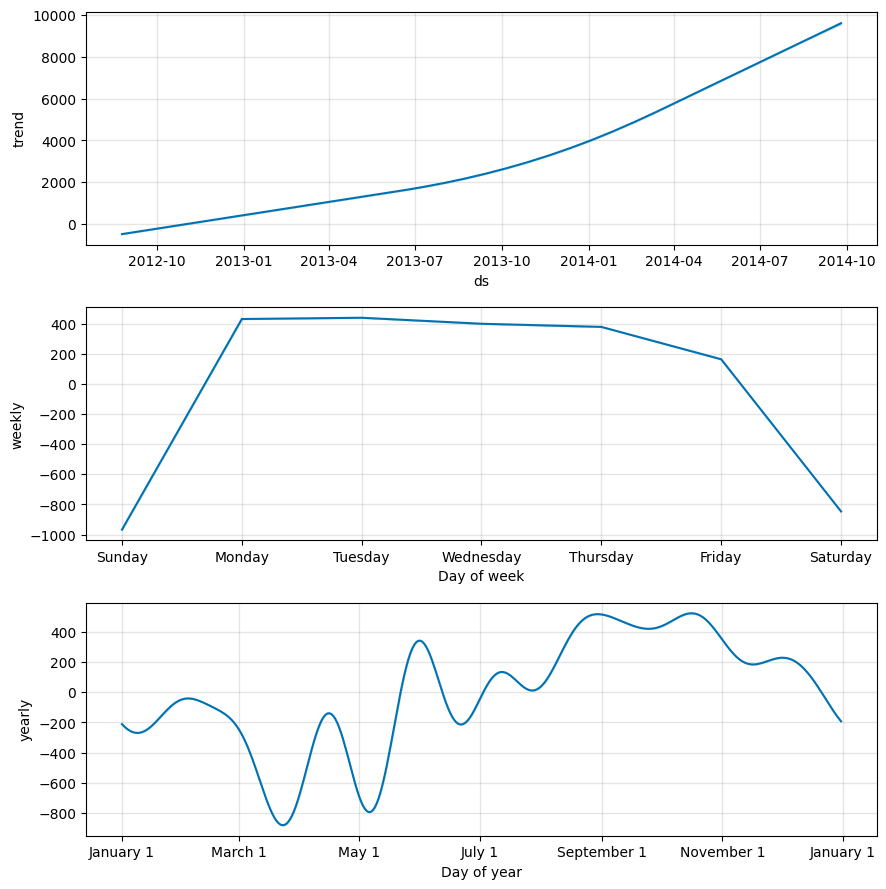

In [18]:
model.plot_components(forecast)

In [19]:
pred = forecast.iloc[-60:, :]
len(pred)

60

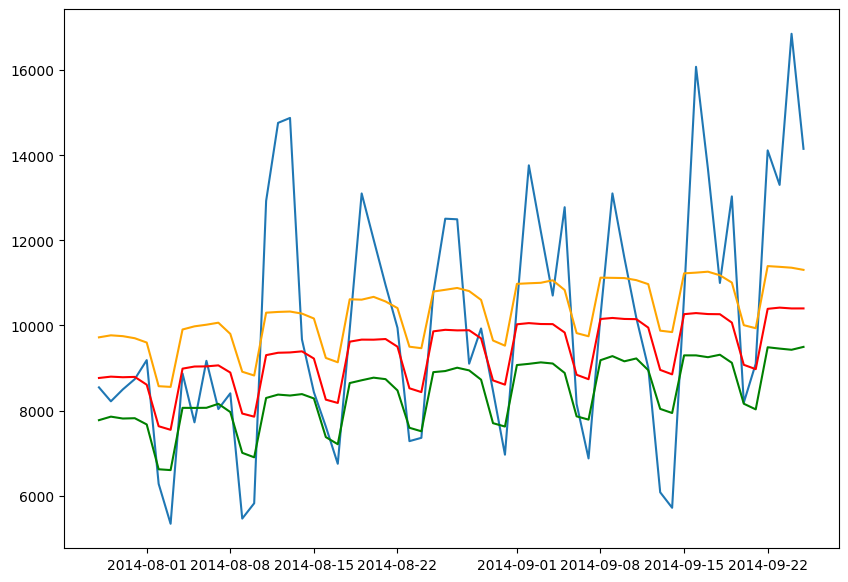

In [20]:
# plotting the test results
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'])
plt.plot(pred['ds'], pred['yhat'], color='red')
plt.plot(pred['ds'], pred['yhat_lower'], color='green')
plt.plot(pred['ds'], pred['yhat_upper'], color='orange')
plt.show()


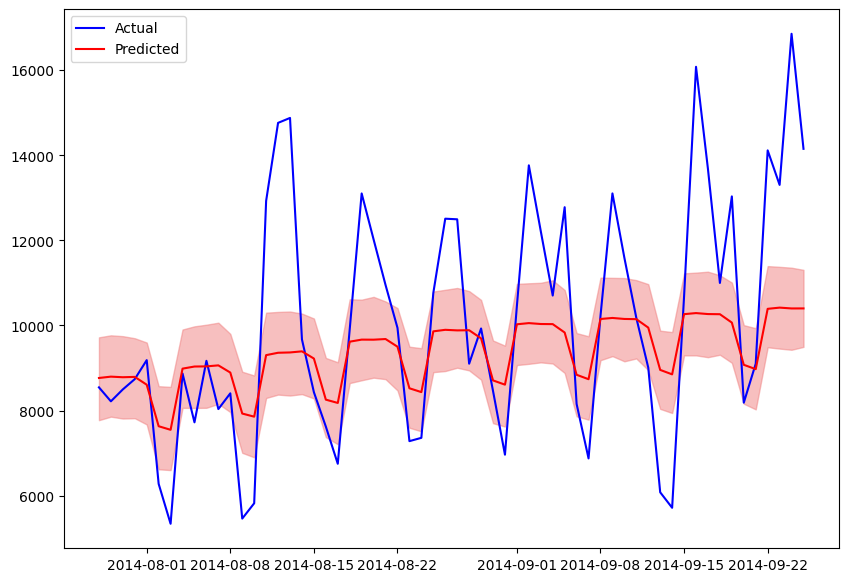

In [21]:
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')  # Added label for actual values
plt.plot(pred['ds'], pred['yhat'], color='red', label='Predicted')  # Predicted values in red
plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading
plt.legend()  # Show legend
plt.show()

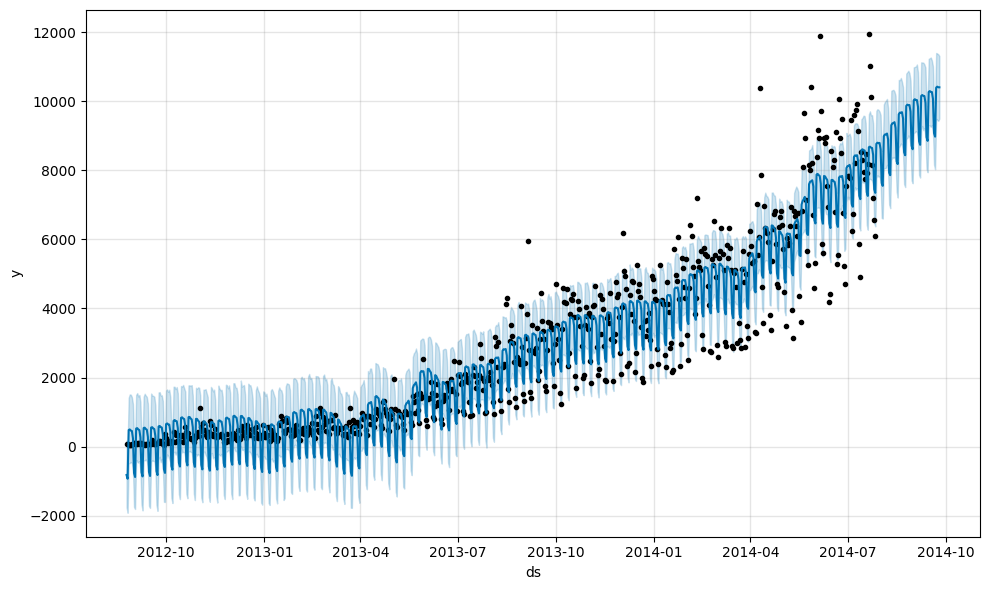

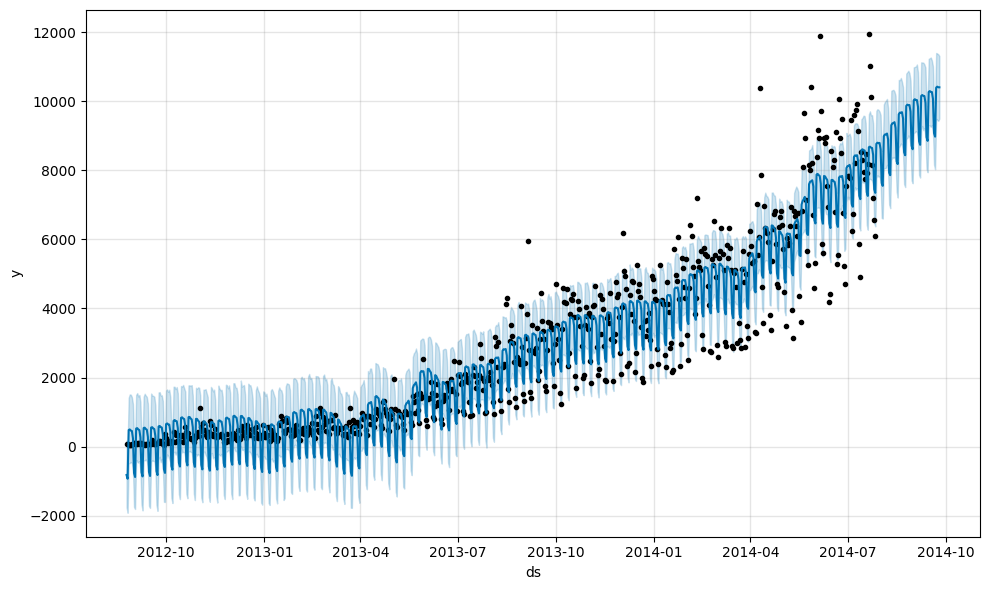

In [22]:
model.plot(forecast)

## Evaluate the Model

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Prophet Model 1:')
print()

# Calculate MAE
mae = mean_absolute_error(test['y'], pred['yhat'])
print(f'MAE: {mae:.3f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'], pred['yhat']))
print(f'RMSE: {rmse:.3f}')


# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['y'], pred['yhat'])
print(f'MAPE: {mape:.2f} %')

# Calculate R-squared
r2 = r2_score(test['y'], pred['yhat'])
print(f'R-squared: {r2:.3f}')

Prophet Model 1:

MAE: 1745.596
RMSE: 2349.592
MAPE: 16.84 %
R-squared: 0.295


## Hyperparameter Tuning

### Grid Search CV

In [24]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Define the parameter grid for tuning
param_grid = {
    'yearly_seasonality': [True],
    'seasonality_prior_scale': [0.1, 0.7, 0.75, 0.8, 0.9, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1]
}

best_rmse = float('inf')
best_params = {}

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(train)
    
    # Forecasting
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Calculate RMSE for the predictions
    rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-len(test):]))
    
    # Check if this is the best RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_model = model

print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')

12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1]

Best RMSE: 2284.0653738893066
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.8, 'yearly_seasonality': True}


In [25]:
model2 = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.8, yearly_seasonality=True)
model2.fit(train)
forecast2 = model2.predict(future)

12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
pred2 = forecast2.iloc[-60:, :]

### Evaluating Improved Model

In [27]:
print('Prophet Hyperparameter Tuned Model:')
print()

# Calculate MAE
mae = mean_absolute_error(test['y'], pred2['yhat'])
print(f'MAE: {mae:.3f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'], pred2['yhat']))
print(f'RMSE: {rmse:.3f}')


# Calculate MAPE
mape = mean_absolute_percentage_error(test['y'], pred2['yhat'])
print(f'MAPE: {mape:.2f} %')

# Calculate R-squared
r2 = r2_score(test['y'], pred2['yhat'])
print(f'R-squared: {r2:.3f}')

Prophet Hyperparameter Tuned Model:

MAE: 1718.466
RMSE: 2284.065
MAPE: 17.03 %
R-squared: 0.334


The above model's RMSE score & MAE score was just barely better than our first baseline model. We can also see interestingly that the MAPE is higher than before. Therefore let's try tuning the parameters further using Baysian Optimization.

### Bayesian Optimization

In [28]:
from bayes_opt import BayesianOptimization
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Define the objective function
def objective(yearly_seasonality, seasonality_prior_scale, changepoint_prior_scale):
    model = Prophet(yearly_seasonality=yearly_seasonality,
                    seasonality_prior_scale=seasonality_prior_scale,
                    changepoint_prior_scale=changepoint_prior_scale)
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-len(test):]))
    return -rmse  # We negate RMSE because BayesianOptimization maximizes the function

# Define the parameter bounds
pbounds = {
    'yearly_seasonality': (0, 1),  # Treating boolean as continuous for optimization
    'seasonality_prior_scale': (0.1, 1),
    'changepoint_prior_scale': (0.001, 0.105),
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)

# Run the optimization
optimizer.maximize(init_points=20, n_iter=150)

print("Best parameters:", optimizer.max['params'])
print("Best RMSE:", -optimizer.max['target'])  # Negate back to get RMSE

12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing


|   iter    |  target   | change... | season... | yearly... |
-------------------------------------------------------------
| 1         | -2.504e+0 | 0.04437   | 0.7483    | 0.0001144 |


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing


| 2         | -2.507e+0 | 0.03244   | 0.2321    | 0.09234   |
| 3         | -2.677e+0 | 0.02037   | 0.411     | 0.3968    |


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing


| 4         | -2.438e+0 | 0.05704   | 0.4773    | 0.6852    |
| 5         | -2.623e+0 | 0.02226   | 0.8903    | 0.02739   |


12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing


| 6         | -2.415e+0 | 0.07073   | 0.4756    | 0.5587    |
| 7         | -2.761e+0 | 0.0156    | 0.2783    | 0.8007    |


12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing


| 8         | -2.374e+0 | 0.1017    | 0.3821    | 0.6923    |
| 9         | -2.408e+0 | 0.09214   | 0.9051    | 0.08504   |


12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing


| 10        | -3.331e+0 | 0.005062  | 0.2528    | 0.8781    |
| 11        | -2.902e+0 | 0.01123   | 0.479     | 0.9579    |


12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing


| 12        | -2.438e+0 | 0.05645   | 0.7227    | 0.3155    |
| 13        | -2.424e+0 | 0.0724    | 0.8512    | 0.01829   |


12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing


| 14        | -2.416e+0 | 0.07902   | 0.99      | 0.7482    |
| 15        | -2.571e+0 | 0.03017   | 0.8104    | 0.1032    |


12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing


| 16        | -2.495e+0 | 0.04758   | 0.9177    | 0.2936    |
| 17        | -2.57e+03 | 0.03093   | 0.217     | 0.01937   |


12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing


| 18        | -2.424e+0 | 0.0716    | 0.2905    | 0.2655    |
| 19        | -2.494e+0 | 0.05212   | 0.148     | 0.5741    |


12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing


| 20        | -2.751e+0 | 0.01626   | 0.6304    | 0.6998    |


12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing


| 21        | -2.505e+0 | 0.04009   | 0.8109    | 0.7744    |
| 22        | -2.475e+0 | 0.05636   | 0.8086    | 0.1749    |


12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing


| 23        | -2.442e+0 | 0.06297   | 0.3349    | 0.7467    |


12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing


| 24        | -2.635e+0 | 0.02466   | 0.24      | 0.9473    |


12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing


| 25        | -2.415e+0 | 0.07653   | 0.7558    | 0.1947    |


12:11:03 - cmdstanpy - INFO - Chain [1] start processing


| 26        | -2.46e+03 | 0.04991   | 0.4811    | 0.4719    |


12:11:03 - cmdstanpy - INFO - Chain [1] done processing


| 27        | -2.383e+0 | 0.1004    | 0.6977    | 0.4707    |


12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing


| 28        | -2.496e+0 | 0.05183   | 0.8571    | 0.9791    |


12:11:04 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


| 29        | -2.561e+0 | 0.03454   | 0.7872    | 0.857     |


12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


| 30        | -2.4e+03  | 0.08991   | 0.7474    | 0.912     |


12:11:05 - cmdstanpy - INFO - Chain [1] start processing


| 31        | -2.43e+03 | 0.07142   | 0.5931    | 0.3832    |


12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing


| 32        | -2.756e+0 | 0.01564   | 0.2254    | 0.3168    |


12:11:05 - cmdstanpy - INFO - Chain [1] done processing


| 33        | -2.578e+0 | 0.0295    | 0.7879    | 0.06687   |


12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing


| 34        | -2.429e+0 | 0.06647   | 0.6822    | 0.4027    |


12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing


| 35        | -2.454e+0 | 0.06321   | 0.2014    | 0.1168    |
| 36        | -2.442e+0 | 0.06482   | 0.6017    | 0.6536    |


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


| 37        | -2.363e+0 | 0.08633   | 0.5689    | 0.573     |


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


| 38        | -2.45e+03 | 0.06371   | 0.6135    | 0.5043    |


12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing


| 39        | -2.358e+0 | 0.1048    | 0.5369    | 0.646     |


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


| 40        | -2.524e+0 | 0.03513   | 0.369     | 0.6368    |


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


| 41        | -2.647e+0 | 0.02352   | 0.5408    | 0.5964    |


12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


| 42        | -2.635e+0 | 0.02492   | 0.1583    | 0.7038    |


12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing


| 43        | -2.392e+0 | 0.1016    | 0.643     | 0.5826    |


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing


| 44        | -2.435e+0 | 0.06324   | 0.2036    | 0.4092    |


12:11:10 - cmdstanpy - INFO - Chain [1] done processing


| 45        | -2.398e+0 | 0.08828   | 0.4767    | 0.2961    |


12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing


| 46        | -2.394e+0 | 0.0991    | 0.3753    | 0.2469    |


12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1] done processing
12:11:11 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1] done processing


| 47        | -2.403e+0 | 0.09466   | 0.2928    | 0.1746    |
| 48        | -3.269e+0 | 0.005471  | 0.4734    | 0.005292  |


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing


| 49        | -2.392e+0 | 0.1008    | 0.5928    | 0.257     |


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing


| 50        | -3.342e+0 | 0.005031  | 0.573     | 0.2745    |


12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing


| 51        | -2.372e+0 | 0.1045    | 0.679     | 0.2562    |


12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing


| 52        | -2.884e+0 | 0.01173   | 0.1514    | 0.3696    |


12:11:13 - cmdstanpy - INFO - Chain [1] done processing


| 53        | -2.496e+0 | 0.04644   | 0.2741    | 0.07577   |


12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


| 54        | -2.366e+0 | 0.08571   | 0.7507    | 0.9205    |


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


| 55        | -2.419e+0 | 0.0819    | 0.6954    | 0.993     |


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing


| 56        | -2.383e+0 | 0.101     | 0.2345    | 0.482     |


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


| 57        | -2.397e+0 | 0.1003    | 0.8102    | 0.3823    |


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


| 58        | -2.418e+0 | 0.06568   | 0.8071    | 0.4994    |


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


| 59        | -2.423e+0 | 0.07985   | 0.907     | 0.6438    |
| 60        | -2.6e+03  | 0.02749   | 0.8609    | 0.1307    |


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


| 61        | -2.414e+0 | 0.07949   | 0.3127    | 0.8752    |


12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing
12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing


| 62        | -2.388e+0 | 0.103     | 0.3831    | 0.8162    |
| 63        | -2.412e+0 | 0.08533   | 0.7725    | 0.8895    |


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


| 64        | -2.37e+03 | 0.105     | 0.3011    | 0.9864    |


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


| 65        | -2.337e+0 | 0.105     | 0.1985    | 1.0       |


12:11:18 - cmdstanpy - INFO - Chain [1] start processing
12:11:18 - cmdstanpy - INFO - Chain [1] done processing


| 66        | -2.339e+0 | 0.105     | 0.1       | 1.0       |


12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


| 67        | -2.636e+0 | 0.02401   | 0.1098    | 0.9919    |


12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing


| 68        | -2.361e+0 | 0.1019    | 0.9331    | 0.4806    |


12:11:20 - cmdstanpy - INFO - Chain [1] done processing


| 69        | -2.785e+0 | 0.01423   | 0.9405    | 0.5243    |


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing


| 70        | -2.377e+0 | 0.105     | 0.9168    | 0.3981    |


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


| 71        | -2.388e+0 | 0.1043    | 0.7826    | 0.5902    |


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1] done processing


| 72        | -3.262e+0 | 0.005389  | 0.6919    | 0.9912    |


12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing
12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


| 73        | -2.387e+0 | 0.1036    | 0.7906    | 0.9694    |


12:11:22 - cmdstanpy - INFO - Chain [1] start processing


| 74        | -2.87e+03 | 0.0123    | 0.8339    | 0.9746    |


12:11:22 - cmdstanpy - INFO - Chain [1] done processing
12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing


| 75        | -2.356e+0 | 0.09166   | 0.2607    | 0.4188    |
| 76        | -3.015e+0 | 0.008479  | 0.2405    | 0.6775    |


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


| 77        | -2.348e+0 | 0.105     | 0.9039    | 0.924     |


12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing


| 78        | -2.354e+0 | 0.105     | 0.9364    | 1.0       |


12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing
12:11:24 - cmdstanpy - INFO - Chain [1] start processing


| 79        | -2.426e+0 | 0.07463   | 1.0       | 0.9173    |


12:11:24 - cmdstanpy - INFO - Chain [1] done processing


| 80        | -2.598e+0 | 0.02776   | 0.7674    | 0.661     |


12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing


| 81        | -2.375e+0 | 0.105     | 0.9106    | 0.8167    |


12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing


| 82        | -2.956e+0 | 0.00997   | 0.5925    | 0.145     |


12:11:25 - cmdstanpy - INFO - Chain [1] done processing


| 83        | -3.794e+0 | 0.002069  | 0.9359    | 0.8206    |


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing


| 84        | -2.357e+0 | 0.1041    | 0.8444    | 0.7113    |


12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing


| 85        | -2.37e+03 | 0.1002    | 0.9978    | 0.6404    |


12:11:27 - cmdstanpy - INFO - Chain [1] done processing


| 86        | -2.374e+0 | 0.105     | 0.3638    | 0.5185    |


12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing


| 87        | -2.392e+0 | 0.1003    | 0.9998    | 0.1711    |


12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing


| 88        | -2.361e+0 | 0.105     | 1.0       | 0.03749   |


12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1] done processing
12:11:28 - cmdstanpy - INFO - Chain [1] start processing


| 89        | -2.361e+0 | 0.105     | 1.0       | 0.4153    |


12:11:28 - cmdstanpy - INFO - Chain [1] done processing
12:11:28 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


| 90        | -3.118e+0 | 0.006391  | 0.8064    | 0.3772    |
| 91        | -2.495e+0 | 0.04867   | 0.9724    | 0.569     |


12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


| 92        | -2.35e+03 | 0.1041    | 0.998     | 0.3182    |


12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing


| 93        | -2.777e+0 | 0.01498   | 0.9448    | 0.009471  |


12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing


| 94        | -2.354e+0 | 0.1036    | 0.7962    | 0.279     |


12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing


| 95        | -2.692e+0 | 0.01938   | 0.2883    | 0.5306    |


12:11:30 - cmdstanpy - INFO - Chain [1] done processing


| 96        | -2.366e+0 | 0.08684   | 0.2079    | 0.5583    |


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing


| 97        | -2.359e+0 | 0.105     | 0.5034    | 0.7754    |


12:11:31 - cmdstanpy - INFO - Chain [1] done processing


| 98        | -2.351e+0 | 0.1008    | 0.3828    | 0.692     |


12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


| 99        | -2.44e+03 | 0.06187   | 0.4096    | 0.7032    |


12:11:32 - cmdstanpy - INFO - Chain [1] start processing
12:11:32 - cmdstanpy - INFO - Chain [1] done processing


| 100       | -2.398e+0 | 0.09514   | 0.4138    | 0.6552    |


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing
12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


| 101       | -2.351e+0 | 0.105     | 0.8822    | 0.9775    |
| 102       | -2.411e+0 | 0.08343   | 0.2268    | 0.7923    |


12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing


| 103       | -2.361e+0 | 0.105     | 0.741     | 0.2599    |


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing


| 104       | -2.508e+0 | 0.04156   | 0.1318    | 0.1549    |


12:11:34 - cmdstanpy - INFO - Chain [1] start processing
12:11:34 - cmdstanpy - INFO - Chain [1] done processing


| 105       | -2.438e+0 | 0.06591   | 0.9316    | 0.9595    |


12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing


| 106       | -2.43e+03 | 0.06931   | 0.9718    | 0.3712    |


12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing


| 107       | -2.371e+0 | 0.1017    | 0.8353    | 0.9256    |


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


| 108       | -2.373e+0 | 0.09313   | 0.7315    | 0.5366    |


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


| 109       | -2.383e+0 | 0.1003    | 0.5305    | 0.7108    |


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


| 110       | -2.362e+0 | 0.105     | 0.9808    | 0.1016    |


12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing


| 111       | -2.364e+0 | 0.1036    | 0.9128    | 0.7191    |


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


| 112       | -2.381e+0 | 0.105     | 0.1494    | 0.9552    |


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


| 113       | -2.45e+03 | 0.06747   | 0.1892    | 0.1435    |


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


| 114       | -2.354e+0 | 0.105     | 0.6549    | 0.3279    |


12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


| 115       | -2.363e+0 | 0.1027    | 0.3505    | 0.921     |


12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing


| 116       | -2.5e+03  | 0.04245   | 0.6904    | 0.2842    |


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing


| 117       | -2.369e+0 | 0.1025    | 0.8613    | 0.457     |


12:11:40 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing


| 118       | -2.361e+0 | 0.105     | 0.8607    | 0.5471    |


12:11:41 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing


| 119       | -2.391e+0 | 0.1028    | 0.9877    | 0.2488    |


12:11:41 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing


| 120       | -2.562e+0 | 0.03168   | 0.1077    | 0.1558    |


12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing


| 121       | -2.378e+0 | 0.09463   | 0.8334    | 0.6691    |


12:11:42 - cmdstanpy - INFO - Chain [1] done processing


| 122       | -2.391e+0 | 0.1049    | 0.1519    | 0.4861    |


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


| 123       | -2.688e+0 | 0.01842   | 0.3464    | 0.2011    |


12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing
12:11:43 - cmdstanpy - INFO - Chain [1] start processing


| 124       | -2.385e+0 | 0.09922   | 0.9186    | 0.1806    |


12:11:43 - cmdstanpy - INFO - Chain [1] done processing


| 125       | -2.426e+0 | 0.0726    | 0.623     | 0.4067    |


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


| 126       | -2.677e+0 | 0.02035   | 0.9809    | 0.2009    |


12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing


| 127       | -2.372e+0 | 0.105     | 0.5346    | 0.5063    |


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


| 128       | -2.375e+0 | 0.105     | 0.4604    | 0.844     |


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing


| 129       | -2.418e+0 | 0.06812   | 0.2841    | 0.6585    |


12:11:45 - cmdstanpy - INFO - Chain [1] start processing
12:11:45 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing


| 130       | -2.382e+0 | 0.105     | 0.3294    | 0.4489    |


12:11:46 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing


| 131       | -2.36e+03 | 0.09399   | 0.7308    | 0.5357    |


12:11:46 - cmdstanpy - INFO - Chain [1] done processing


| 132       | -2.41e+03 | 0.09504   | 0.1483    | 0.1339    |


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing


| 133       | -2.36e+03 | 0.1013    | 0.8585    | 0.2341    |


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing


| 134       | -2.513e+0 | 0.04196   | 0.9908    | 0.6726    |


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


| 135       | -2.393e+0 | 0.105     | 0.5498    | 0.8359    |


12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing
12:11:48 - cmdstanpy - INFO - Chain [1] start processing


| 136       | -2.381e+0 | 0.1001    | 0.7741    | 0.449     |


12:11:48 - cmdstanpy - INFO - Chain [1] done processing


| 137       | -2.409e+0 | 0.08298   | 0.2275    | 0.7919    |


12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


| 138       | -2.388e+0 | 0.1038    | 0.6767    | 0.5246    |


12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


| 139       | -2.518e+0 | 0.03509   | 0.5108    | 0.8005    |


12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


| 140       | -2.392e+0 | 0.105     | 0.2791    | 0.5915    |


12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


| 141       | -2.39e+03 | 0.105     | 0.3282    | 0.3414    |


12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing


| 142       | -2.361e+0 | 0.105     | 1.0       | 0.9966    |


12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing


| 143       | -2.393e+0 | 0.105     | 0.4061    | 0.3171    |


12:11:52 - cmdstanpy - INFO - Chain [1] start processing
12:11:52 - cmdstanpy - INFO - Chain [1] done processing


| 144       | -3.334e+0 | 0.00521   | 0.5795    | 0.439     |


12:11:52 - cmdstanpy - INFO - Chain [1] start processing
12:11:52 - cmdstanpy - INFO - Chain [1] done processing


| 145       | -2.367e+0 | 0.105     | 0.437     | 0.4941    |


12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing


| 146       | -2.445e+0 | 0.02177   | 1.0       | 1.0       |


12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing


| 147       | -2.378e+0 | 0.1043    | 0.8746    | 0.3212    |


12:11:54 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing


| 148       | -2.384e+0 | 0.105     | 0.4561    | 0.2181    |


12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing


| 149       | -2.355e+0 | 0.105     | 0.1       | 0.04174   |


12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing


| 150       | -2.516e+0 | 0.03539   | 0.1       | 0.0       |


12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing


| 151       | -2.355e+0 | 0.105     | 0.1       | 0.8782    |


12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing


| 152       | -2.402e+0 | 0.08922   | 0.1074    | 0.8054    |


12:11:57 - cmdstanpy - INFO - Chain [1] start processing
12:11:57 - cmdstanpy - INFO - Chain [1] done processing


| 153       | -2.334e+0 | 0.105     | 0.3784    | 1.0       |


12:11:57 - cmdstanpy - INFO - Chain [1] start processing
12:11:57 - cmdstanpy - INFO - Chain [1] done processing


| 154       | -2.434e+0 | 0.07066   | 0.7029    | 0.489     |


12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing


| 155       | -2.468e+0 | 0.04359   | 0.8627    | 0.5343    |


12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing


| 156       | -2.505e+0 | 0.04496   | 0.3482    | 0.9915    |


12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing


| 157       | -2.353e+0 | 0.105     | 0.3949    | 0.1435    |


12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing


| 158       | -2.367e+0 | 0.1043    | 0.837     | 0.8133    |


12:12:00 - cmdstanpy - INFO - Chain [1] start processing
12:12:00 - cmdstanpy - INFO - Chain [1] done processing


| 159       | -2.359e+0 | 0.09983   | 0.3588    | 0.07502   |


12:12:00 - cmdstanpy - INFO - Chain [1] start processing
12:12:00 - cmdstanpy - INFO - Chain [1] done processing


| 160       | -2.353e+0 | 0.1033    | 0.3165    | 0.001965  |


12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing


| 161       | -2.374e+0 | 0.105     | 0.4992    | 0.3817    |


12:12:01 - cmdstanpy - INFO - Chain [1] done processing


| 162       | -2.392e+0 | 0.1045    | 0.6436    | 0.826     |


12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing


| 163       | -2.351e+0 | 0.105     | 0.7422    | 0.772     |


12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing


| 164       | -2.363e+0 | 0.105     | 0.6501    | 0.9263    |


12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing


| 165       | -2.442e+0 | 0.06089   | 0.8487    | 0.8492    |


12:12:03 - cmdstanpy - INFO - Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing


| 166       | -2.386e+0 | 0.1016    | 0.577     | 0.9163    |


12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing


| 167       | -2.361e+0 | 0.105     | 1.0       | 0.5097    |
| 168       | -2.5e+03  | 0.04867   | 0.8389    | 0.2987    |


12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


| 169       | -2.37e+03 | 0.105     | 0.673     | 0.7438    |


12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


| 170       | -2.392e+0 | 0.104     | 0.6287    | 0.984     |
Best parameters: {'changepoint_prior_scale': 0.105, 'seasonality_prior_scale': 0.3783764682353072, 'yearly_seasonality': 1.0}
Best RMSE: 2334.2656043550737


From the above cell, it seems that the best RMSE score is still very close to the previous models. Let us evaluate all the other metrics for these set of parameters:

In [29]:
model3 = Prophet(changepoint_prior_scale=0.105, seasonality_prior_scale=0.3783764682353072, yearly_seasonality=1.0)
model3.fit(train)
forecast3 = model3.predict(future)
pred3 = forecast3.iloc[-60:, :]

12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
print('Prophet Model Hyperparameter Tuned using Bayesian Optimization:')
print()

# Calculate MAE
mae = mean_absolute_error(test['y'], pred3['yhat'])
print(f'MAE: {mae:.3f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'], pred3['yhat']))
print(f'RMSE: {rmse:.3f}')


# Calculate MAPE
mape = mean_absolute_percentage_error(test['y'], pred3['yhat'])
print(f'MAPE: {mape:.2f} %')

# Calculate R-squared
r2 = r2_score(test['y'], pred3['yhat'])
print(f'R-squared: {r2:.3f}')

Prophet Model Hyperparameter Tuned using Bayesian Optimization:

MAE: 1768.046
RMSE: 2334.266
MAPE: 17.35 %
R-squared: 0.304


## Comparing Prophet Models
<table>
    <tr>
        <th>Model</th>
        <th>MAE</th>
        <th>RMSE</th>
        <th>MAPE</th>
        <th>R-squared</th>
    </tr>
    <tr>
        <td>Prophet Model 1 (Baseline)</td>
        <td >1745.596</td>
        <td style="color: red;">2349.592</td>
        <td style="color: green;">16.84 %</td>
        <td style="color: red;">0.295</td>
    </tr>
    <tr>
        <td style="color: green;">Prophet Hyperparameter Tuned (GridSearchCV)</td>
        <td style="color: green;">1718.466</td>
        <td style="color: green;">2284.065</td>
        <td>17.03 %</td>
        <td style="color: green;">0.334</td>
    </tr>
    <tr>
        <td >Prophet Hyperparameter Tuned (Bayesian Optimization)</td>
        <td style="color: red;">1768.046</td>
        <td>2334.266</td>
        <td style="color: red;">17.35 %</td>
        <td>0.304</td>
    </tr>
</table>

<small>Note: Hyper-parameters were optimized for RMSE</small>

It was surprising to see that the Bayesian Optimization led to results which were just barely better than the baseline model in terms of the RMSE score & R-squared, and worse in terms of MAE & MAPE. 

We can see that the second model (in this case with GridSearchCV) was the overall best performing model because of the following reasons:
1. It has the best performance on 3 out of 4 metrics:
   - lowest MAE, 
   - lowest RMSE  
   - only slightly worse MAPE compared to Model 1.
   - highest R-squared
2. The higher R-squared indicates it captures more of the underlying patterns in the data.

## Visualize Best Model

### Prophet Model: Graphs showing the Overall, Weekly & Yearly Trend

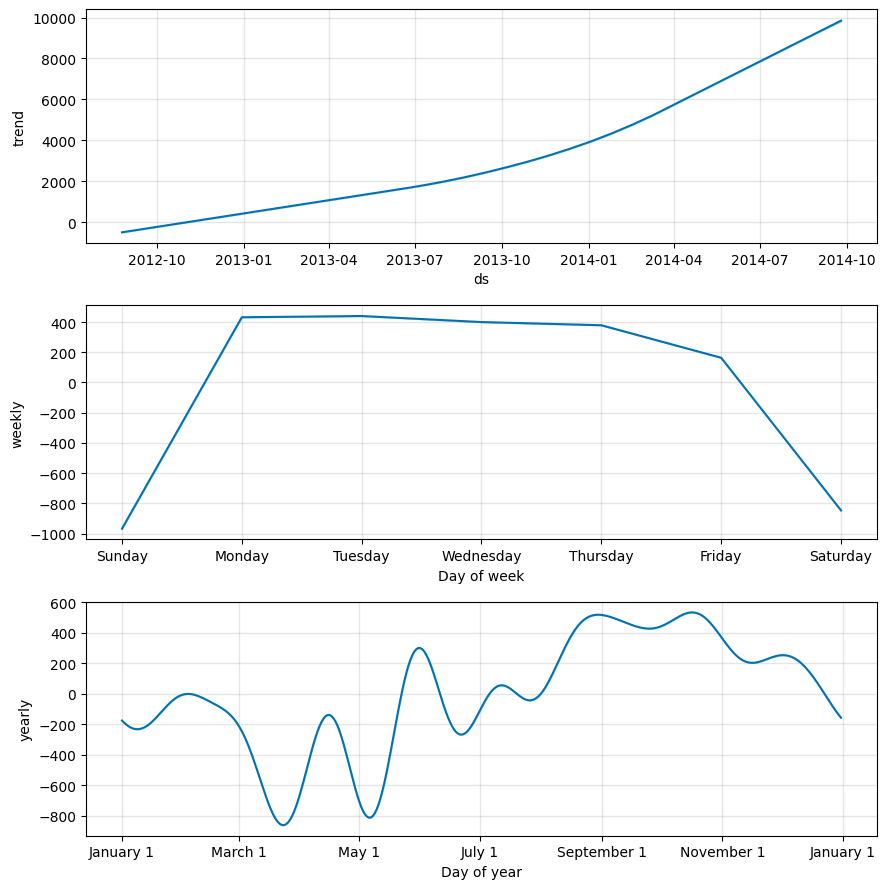

In [65]:
fig2 = model2.plot_components(forecast2)

From the above 3 graphs we can see the following:
1. Exponential growth from 2012 to 2014 on the number of cars on the street.
2. Relatively lower amount of cars on the weekends and much more cars on weekdays. This suggests that the area where the data was collected was likely commercial neighborhood.
3. Between months March & May there was a dip in the number of cars on the street. This coincides with vacations in summer for many employees. The highest cars are present between the months of September to November. After november we can see another dip until January - which coincides with the Winter breaks and vacations.

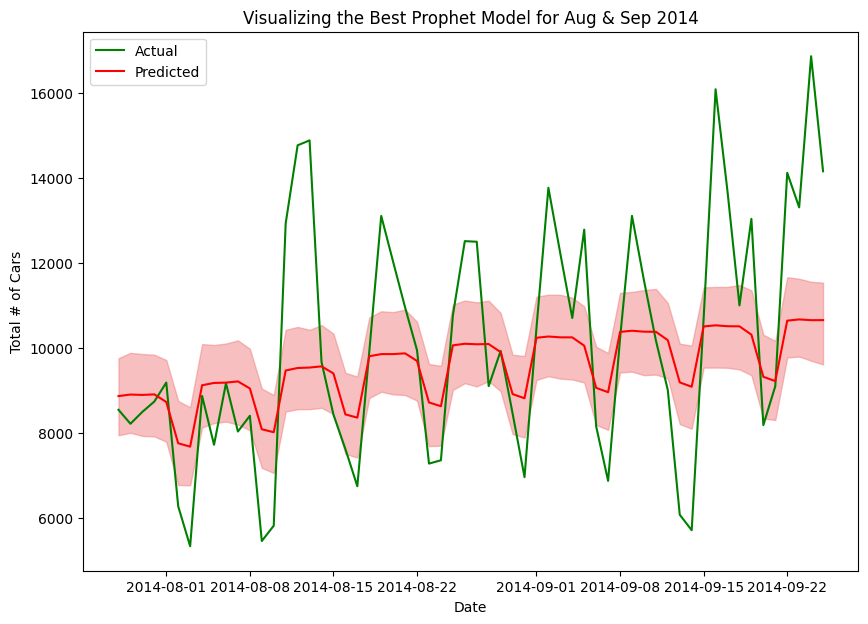

In [49]:
plt.figure(figsize=(10,7))
plt.title("Visualizing the Best Prophet Model for Aug & Sep 2014")
plt.plot(test['ds'], test['y'], label='Actual', color='green')  # Added label for actual values
plt.plot(pred2['ds'], pred2['yhat'], color='red', label='Predicted')  # Predicted values in red
plt.fill_between(pred2['ds'], pred2['yhat_lower'], pred2['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading

plt.xlabel('Date')
plt.ylabel('Total # of Cars')

plt.legend()

### Comparison of Best 2 Prophet Models 

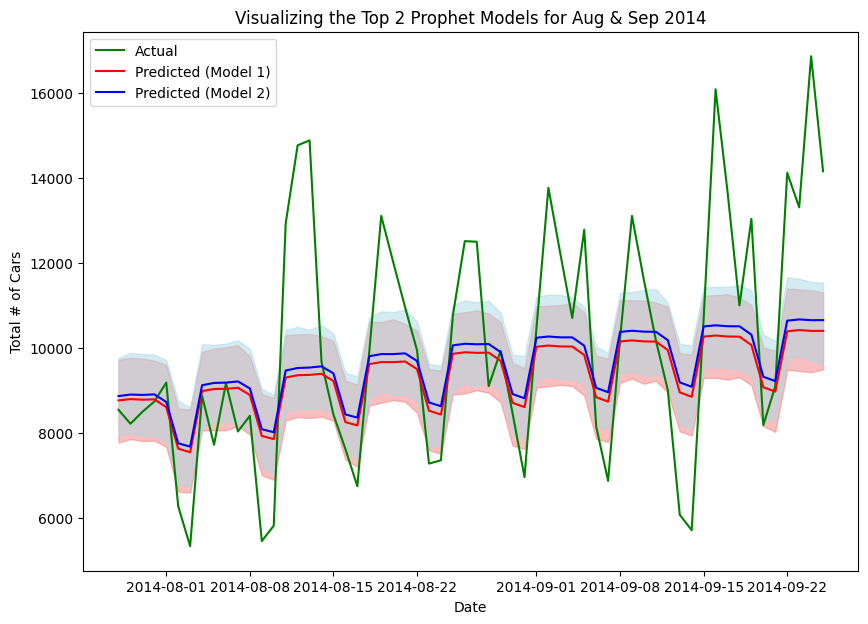

In [48]:
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'], label='Actual', color='green')  # Added label for actual values
plt.plot(pred['ds'], pred['yhat'], color='red', label='Predicted (Model 1)')  # Predicted values in red
plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading
plt.plot(pred2['ds'], pred2['yhat'], color='blue', label='Predicted (Model 2)')  # Predicted values in red
plt.fill_between(pred2['ds'], pred2['yhat_lower'], pred2['yhat_upper'], color='lightblue', alpha=0.5)  # Light red shading

plt.title("Visualizing the Top 2 Prophet Models for Aug & Sep 2014")
plt.xlabel('Date')
plt.ylabel('Total # of Cars')

plt.legend() 


Looks like the second model has slightly improved from the previous, but not significantly better.
Although the values are not exactly close to the test, we can see that our models are generalizing based on the trend. 

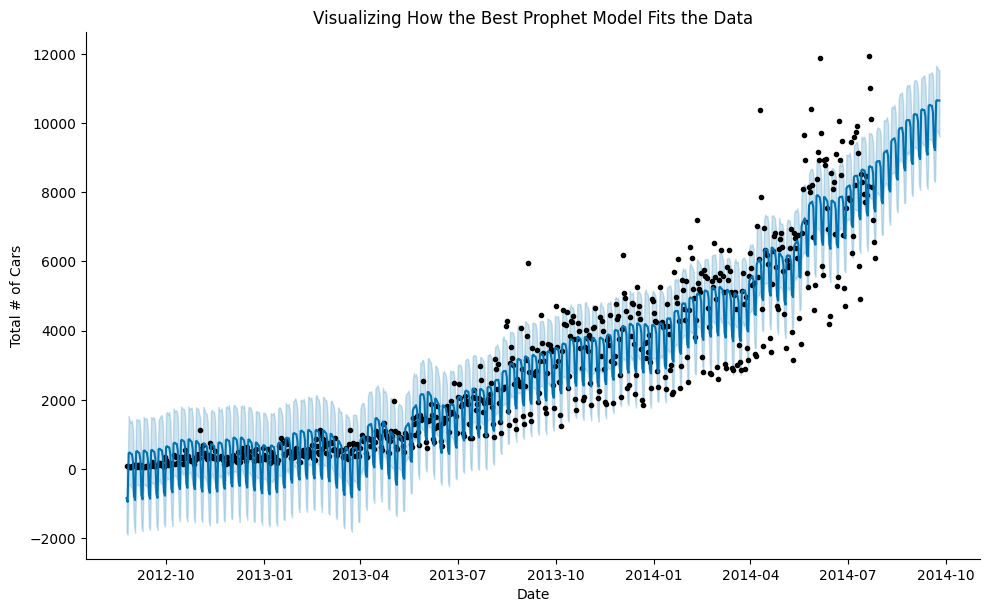

In [60]:
import seaborn as sns
fig1 = model2.plot(forecast2)

plt.title("Visualizing How the Best Prophet Model Fits the Data")
plt.xlabel("Date")
plt.ylabel('Total # of Cars')

# remove the grid lines
plt.grid(False)
sns.despine()

In [54]:
type(fig1)

matplotlib.figure.Figure

## Documentation for Prophet

In [35]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None, scaling: str = 'absmax', holidays_mode=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_

# ML Model: Random Forests

## Data Preparation for the Model

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Extract features from the 'ds' column
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month
train['day'] = train['ds'].dt.day
train['day_of_week'] = train['ds'].dt.dayofweek

test['year'] = test['ds'].dt.year
test['month'] = test['ds'].dt.month
test['day'] = test['ds'].dt.day
test['day_of_week'] = test['ds'].dt.dayofweek

# Prepare the feature set (X) and target variable (y)
X_train = train[['year', 'month', 'day', 'day_of_week']]
X_test = test[['year', 'month', 'day', 'day_of_week']]
y_train = train['y']

## Train the Model

In [38]:
rf_regressor1 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=23, verbose=1, criterion='friedman_mse', oob_score=True)
rf_regressor1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestRegressor(criterion='friedman_mse', max_depth=10, oob_score=True,
                      random_state=23, verbose=1)

In [39]:
rf_predicted_train = rf_regressor1.predict(X_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


## Evaluate the Model

## Hyperparameter Tuning

## Visualize the Best Model

# DL Model: RNN
Recurrent Neural Networks

## Data Preparation for the Model

## Train the Model

## Evaluate the Model

## Hyperparameter Tuning

## Visualize the Best Model

# Statistical/ Mathematical Model: SARIMA